In [6]:
import random, math, json, itertools


def bit_to_qubit(bit, base, use_arrows):
    if use_arrows:
        if bit == '0' and base == '+':
            return '\u2192'
        if bit == '1' and base == '+':
            return '\u2191'
        if bit == '0' and base == 'x':
            return '\u2197'
        if bit == '1' and base == 'x':
            return '\u2196'
    else:
        if bit == '0' and base == '+':
            return '-'
        if bit == '1' and base == '+':
            return '|'
        if bit == '0' and base == 'x':
            return '/'
        if bit == '1' and base == 'x':
            return '\\'

def measure_qubit(o_bit, o_base, m_base, use_arrows):
    if o_base == m_base:
        return bit_to_qubit(o_bit, m_base, use_arrows)
    else:
        return bit_to_qubit(random.choice(['0','1']), m_base, use_arrows)
    
def qubit_to_bit(qubit):
    if qubit in ['\u2192', '\u2197', '-', '/']:
        return '0'
    else:
        return '1'
    

def print_simple(str, use_arrows, block_size, key_len):
    cur_str = ''
    for index in range(key_len):
        cur_str += f'{" " if (index % block_size == 0) else ""}{" " if use_arrows and (index % block_size == 0) else ""}{str[index]} '
    print(cur_str)

def print_wide(qubits, use_arrows, block_size, key_len):
    cur_str = f'{" " if use_arrows else ""}'
    for index in range(key_len):
        cur_str += f'{" " if (index % block_size == 0) else ""}{qubits[index]} '
    print(cur_str)


def sim(key_len, use_eavesdropper):
    resp = {}
    # generate bits and bases
    resp['key_len'] = key_len
    use_arrows = True
    resp['use_arrows'] = use_arrows
    resp['use_eavesdropper'] = use_eavesdropper


    alice_bits = ''.join(random.choices(['0','1'],k=key_len))
    alice_bases = ''.join(random.choices(['+','x'],k=key_len))
    alice_qubits = ''.join(bit_to_qubit(alice_bits[index], alice_bases[index], use_arrows) for index in range(key_len))
    resp['alice_bits'] = alice_bits
    resp['alice_bases'] = alice_bases
    resp['alice_qubits'] = alice_qubits

    if use_eavesdropper:
        eve_bases = ''.join(random.choices(['+','x'],k=key_len))
        eve_measured = ''.join(measure_qubit(alice_bits[index], alice_bases[index], eve_bases[index], use_arrows) for index in range(key_len))
        eve_bits = ''.join(qubit_to_bit(eve_measured[index]) for index in range(key_len))
        resp['eve_bases'] = eve_bases
        resp['eve_measured'] = eve_measured
        resp['eve_bits'] = eve_bits

    bob_bases = ''.join(random.choices(['+','x'],k=key_len))
    bob_measured = ''.join(measure_qubit(eve_bits[index] if use_eavesdropper else alice_bits[index], eve_bases[index] if use_eavesdropper else alice_bases[index], bob_bases[index], use_arrows) for index in range(key_len))
    bob_bits = ''.join(qubit_to_bit(bob_measured[index]) for index in range(key_len))
    resp['bob_bases'] = bob_bases
    resp['bob_measured'] = bob_measured
    resp['bob_bits'] = bob_bits

    matching_bases = ''.join('Y' if alice_bases[index] == bob_bases[index] else '-' for index in range(key_len))
    reveal_indices = random.sample([index for index, value in enumerate(matching_bases) if value == 'Y'], k=math.ceil(matching_bases.count('Y')/4))
    privacy_amp = ''.join(bob_bits[index] if ((matching_bases[index] == 'Y') and (index in reveal_indices)) else '-' for index in range(key_len))
    matching_priv_bits = ''.join('\u2713' if (privacy_amp[index] == alice_bits[index]) else ('x' if privacy_amp[index] != '-' else '-') for index in range(key_len))
    eavesdropper_detected = math.ceil(matching_bases.count('Y')/4) != matching_priv_bits.count('\u2713')
    resp['matching_bases'] = matching_bases
    resp['num_matching_bases'] = matching_bases.count('Y')
    resp['reveal_indices'] = reveal_indices
    resp['privacy_amp'] = privacy_amp
    resp['matching_priv_bits'] = matching_priv_bits
    resp['eavesdropper_detected'] = eavesdropper_detected

    secret_key = ''.join(bob_bits[index] if (matching_bases[index] == 'Y' and index not in reveal_indices) else '' for index in range(key_len))
    resp['secret_key'] = secret_key
    resp['secret_key_len'] = len(secret_key)

    prettyish_print = False
    if prettyish_print:
        block_size = 6
        print_simple(alice_bits, use_arrows, block_size, key_len)
        print_simple(alice_bases, use_arrows, block_size, key_len)
        print_wide(alice_qubits, use_arrows, block_size, key_len)
        print()

        if use_eavesdropper:
            print_simple(eve_bases, use_arrows, block_size, key_len)
            print_wide(eve_measured, use_arrows, block_size, key_len)
            print_simple(eve_bits, use_arrows, block_size, key_len)
            print()
            
        print_simple(bob_bases, use_arrows, block_size, key_len)
        print_wide(bob_measured, use_arrows, block_size, key_len)
        print_simple(bob_bits, use_arrows, block_size, key_len)
        print()

        print_simple(matching_bases, use_arrows, block_size, key_len)
        print_simple(privacy_amp, use_arrows, block_size, key_len)
        print_simple(matching_priv_bits, use_arrows, block_size, key_len)
        print()

        print('matching_bases: ' + str(matching_bases.count('Y')))
        print('revealed_bits: ' + str(math.ceil(matching_bases.count('Y')/4)))
        print('matching_bits: ' + str(matching_priv_bits.count('\u2713')))
        print()

        print('secret_key: ' + secret_key)
        print('secret_key_length: ' + str(len(secret_key)))
    return resp

config = {
    'n': 24,
    'use_eavesdropper': True
}
json_data = {}
for n, use_eavesdropper in itertools.product(list(24*index for index in range(1,11)), [True, False]):
    for i in range(10000):
        sim_resp = sim(n, use_eavesdropper)
        if f'{n}-{use_eavesdropper}' not in json_data:
            json_data[f'{n}-{use_eavesdropper}'] = [sim_resp]
        else:
            json_data[f'{n}-{use_eavesdropper}'] += [sim_resp]

with open('results.json', 'w') as results:
    json.dump(json_data, results, indent=4)

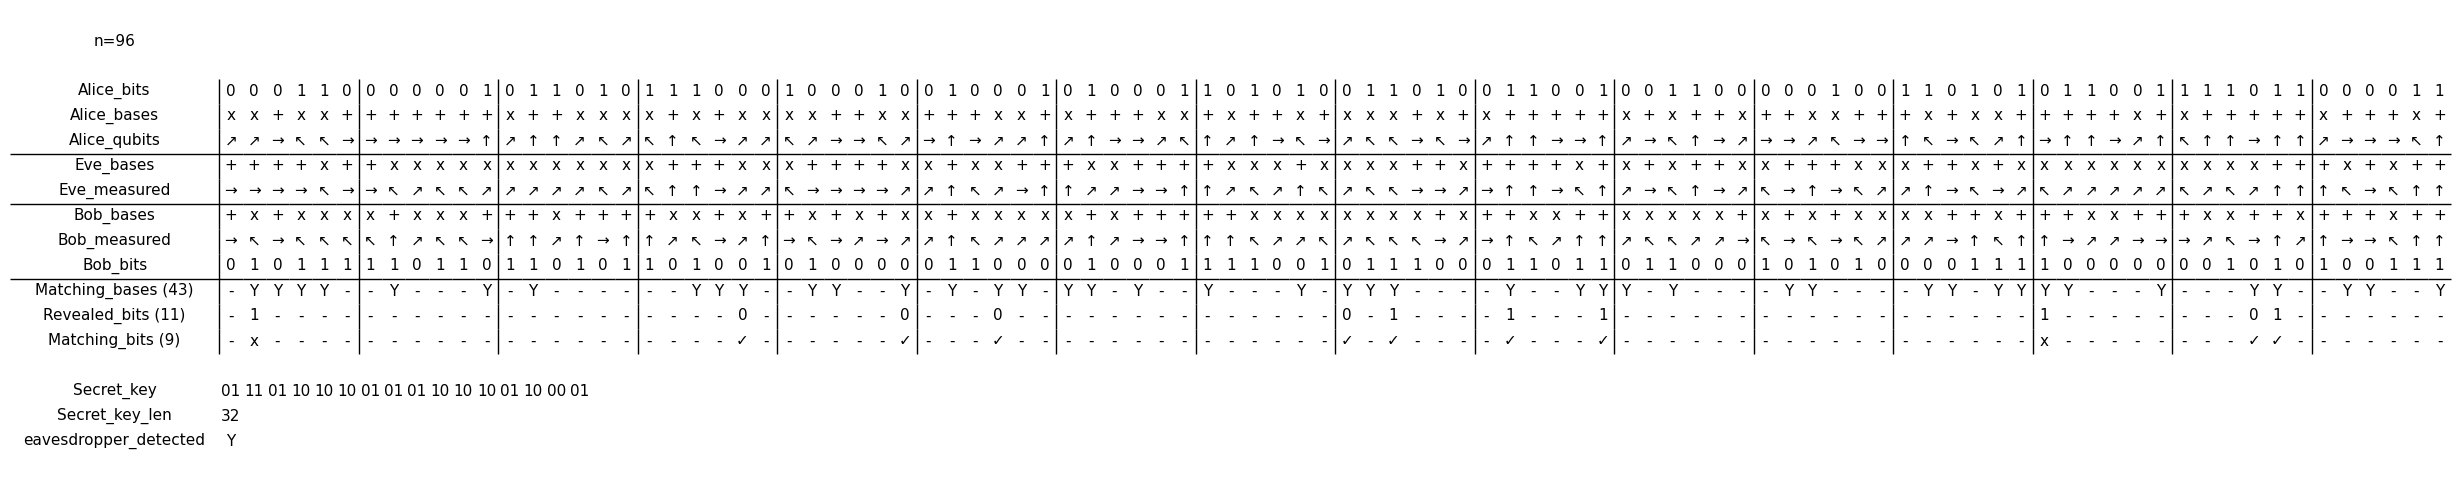

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math

sim_resp = sim(96, True)

data = [
    [f'n={sim_resp["key_len"]}'] + list(''.join(' ' for index in range(sim_resp['key_len']))),
    [''] + list(''.join(' ' for index in range(sim_resp['key_len'])))
]

data += [
    ['Alice_bits'] + list(sim_resp['alice_bits']),
    ['Alice_bases'] + list(sim_resp['alice_bases']),
    ['Alice_qubits'] + list(sim_resp['alice_qubits'])
]

if sim_resp['use_eavesdropper']:
    data += [
        ['Eve_bases'] + list(sim_resp['eve_bases']),
        ['Eve_measured'] + list(sim_resp['eve_measured'])
    ]

data += [
    ['Bob_bases'] + list(sim_resp['bob_bases']),
    ['Bob_measured'] + list(sim_resp['bob_measured']),
    ['Bob_bits'] + list(sim_resp['bob_bits'])
]

num_matching_bits = sim_resp['matching_priv_bits'].count('\u2713')
data += [
    [f'Matching_bases ({str(sim_resp["matching_bases"].count("Y"))})'] + list(sim_resp['matching_bases']),
    [f'Revealed_bits ({str(math.ceil(sim_resp["matching_bases"].count("Y")/4))})'] + list(sim_resp['privacy_amp']),
    [f'Matching_bits ({str(num_matching_bits)})'] + list(sim_resp['matching_priv_bits'])
]

data += [
    [''] + list(''.join(' ' for index in range(sim_resp['key_len']))),
    ['Secret_key'] + list(sim_resp['secret_key'][index:min(index+2,len(sim_resp['secret_key']))] for index in range(0, len(sim_resp['secret_key']), 2)) + list(''.join(' ' for index in range(sim_resp['key_len']-math.ceil(len(sim_resp['secret_key'])/2)))),
    ['Secret_key_len', str(len(sim_resp['secret_key']))] + list(''.join(' ' for index in range(sim_resp['key_len']-1))),
    ['eavesdropper_detected', f'{"Y" if sim_resp["eavesdropper_detected"] else "N"}'] + list(''.join(' ' for index in range(sim_resp['key_len']-1)))
]

data = np.array(data)

rows, cols = data.shape

fig, ax = plt.subplots(figsize=(20, 6))

table = ax.table(cellText=data, loc='center', cellLoc='center')
ax.axis('off')

# remove grid lines
for i in range(0, rows):
    for j in range(0, cols):
        table[i,j].visible_edges = ''
        if (j-1) % 6 == 0 and i < rows-4 and i > 1:
            table[i,j].visible_edges += 'L'
        if i == 4 or (sim_resp['use_eavesdropper'] and i == 6) or (sim_resp['use_eavesdropper'] and i == 9) or (not sim_resp['use_eavesdropper'] and i == 7):
            table[i,j].visible_edges += 'B'

# adjust column widths
col_widths = [0.09] + [0.010] * (cols -1)
for i, width in enumerate(col_widths):
    table._cells[(0, i)].set_width(width)
    for j in range(1, rows):
        table._cells[(j, i)].set_width(width)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.5, 1.5)

plt.show()

In [10]:
import numpy as np
import json

# proportion of times eavesdropper was detected
# if matching_bits != revealed_bits then eavesdropper detected
with open('results.json', 'r') as file:
    results = json.load(file)

data = []
for config in results:
    if 'False' in config:
        continue
    data += [[float(np.mean(np.array(list(1 if result['eavesdropper_detected'] else 0 for result in results[config]))))]]
print(data)

[[0.6174], [0.8348], [0.9294], [0.9695], [0.9883], [0.9946], [0.9973], [0.9993], [0.9998], [0.9999]]


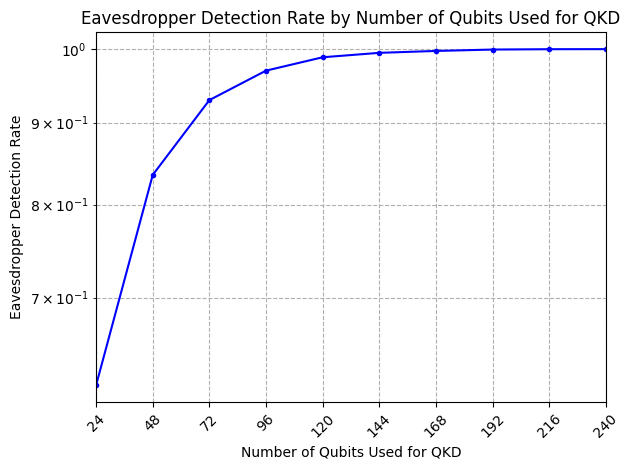

In [11]:
# number of times eavesdropper was detected
# if matching_bits != revealed_bits then eavesdropper detected
configs = [config[:config.index('-')] for config in results if 'False' not in config]

plt.plot(configs, data, color='blue', linestyle='-', marker='o', markersize=3)

plt.xlabel('Number of Qubits Used for QKD')
plt.xticks(rotation=45)
plt.xlim(0,len(configs)-1)

plt.ylabel('Eavesdropper Detection Rate')
plt.yscale('log')

plt.title('Eavesdropper Detection Rate by Number of Qubits Used for QKD')
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


In [12]:
# secret key length
with open('results.json', 'r') as file:
    results = json.load(file)

data = []
for config_index in range(0,len(results), 2): # 24 True, 24 False, 48 True, 48 False, ..., 480 True, 480 False
    data += [[float(np.mean(np.array(list(result['secret_key_len'] for result in results[list(results.keys())[config_index]] if not result['eavesdropper_detected'])))), float(np.mean(np.array(list(result['secret_key_len'] for result in results[list(results.keys())[config_index]])))), float(np.mean(np.array(list(result['secret_key_len'] for result in results[list(results.keys())[config_index+1]]))))]] #[[24true],[]]

print(data)

[[8.274960794563512, 8.6064, 8.5982], [16.999394673123486, 17.6071, 17.611], [25.638810198300284, 26.6567, 26.5784], [33.97704918032787, 35.6258, 35.6184], [42.87179487179487, 44.6214, 44.673], [52.092592592592595, 53.6163, 53.5919], [59.925925925925924, 62.6486, 62.6403], [64.71428571428571, 71.5744, 71.5435], [81.5, 80.7059, 80.6486], [88.0, 89.5821, 89.6614]]


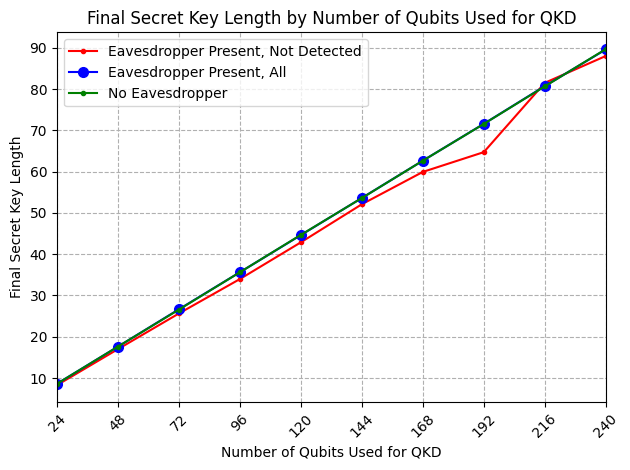

In [13]:
# secret key length
configs = [config[:config.index('-')] for config in results]
data = np.array(data)
trues, wrongs, falses = np.hsplit(data, 3)
plt.plot(configs[::2], trues, label='Eavesdropper Present, Not Detected', color='r', linestyle='-', marker='o', markersize=3)
plt.plot(configs[::2], wrongs, label='Eavesdropper Present, All', color='b', linestyle='-', marker='o', markersize=7)
plt.plot(configs[::2], falses, label='No Eavesdropper', color='g', linestyle='-', marker='o', markersize=3)

plt.xlabel('Number of Qubits Used for QKD')
plt.xticks(rotation=45)
plt.xlim(0,len(configs)/2-1)

plt.ylabel('Final Secret Key Length')

plt.title('Final Secret Key Length by Number of Qubits Used for QKD')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()